In [55]:
from db_functions import db_create_engine
import pandas as pd
import numpy as np
from configparser import ConfigParser
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import metrics

from sql_queries import legislators_sql
% matplotlib inline

print('Python version', sys.version)
print('Pandas version', pd.__version__)
print('Numpy version', np.__version__)

Python version 3.6.3 |Anaconda custom (64-bit)| (default, Oct  6 2017, 12:04:38) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
Pandas version 0.20.3
Numpy version 1.14.0


In [38]:
engine = db_create_engine(config_file='config.ini',
                          conn_name='PostgresConfig')

In [39]:
data = pd.read_sql_query(sql=legislators_sql, con=engine)

In [69]:
data.head()


,party,id,gender,name,religion,twitter_id,location,followers_count,favourites_count,statuses_count,friends_count,tweet_count,tweet_fav_count,retweet_count
0,Republican,R000600,F,Aumua Amata,None,3026622545,"Washington, D.C.",1635.0,161.0,319.0,180.0,10.0,36.0,25.0
1,Republican,Y000064,M,Todd Young,None,234128524,Indiana,34170.0,188.0,3657.0,507.0,72.0,2005.0,750.0
2,Republican,E000295,F,Joni Ernst,None,2856787757,Iowa,32448.0,3.0,1731.0,50.0,38.0,2114.0,607.0
3,Republican,T000476,M,Thom Tillis,None,2964174789,"Washington, D.C.",49229.0,854.0,3112.0,4602.0,43.0,3235.0,1229.0
4,Republican,Y000063,M,Kevin Yoder,None,252819642,KS 3rd District & DC,27618.0,211.0,7082.0,1654.0,50.0,6241.0,4914.0


# Visualization

In [5]:
clean_data = data.dropna(how='any', subset=['twitter_id', 'followers_count', 'tweet_count'])
len(clean_data)

492

In [22]:
clean_data.party.value_counts()
r = round(len(clean_data[clean_data['party']=='Republican'])/len(clean_data), 3) * 100
d = round(len(clean_data[clean_data['party']=='Democrat'])/len(clean_data), 3) * 100

print('{}% Republican - {}'.format(r, len(clean_data[clean_data['party']=='Republican'])))
print('{}% Democrat - {}'.format(d, len(clean_data[clean_data['party']=='Democrat'])))
print('{}% Independent - {}'.format(d, len(clean_data[clean_data['party']=='Independent'])))

53.5% Republican - 263
46.1% Democrat - 227
46.1% Independent - 2


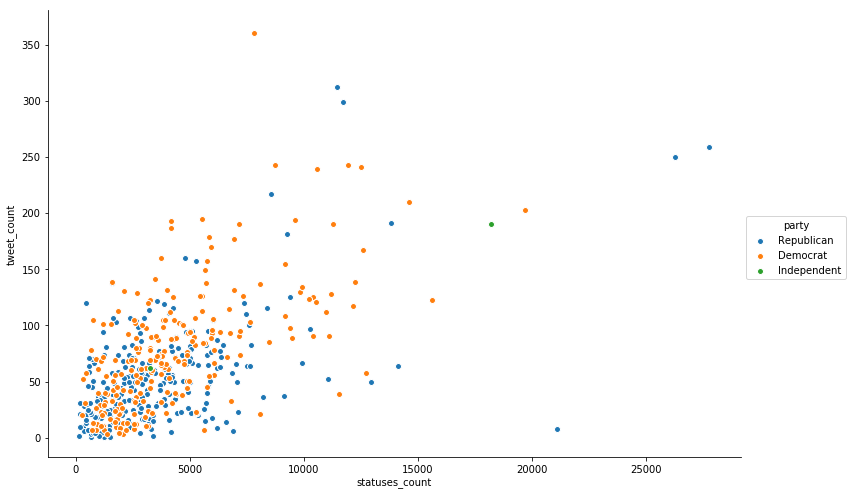

In [7]:
sns.pairplot(x_vars=["statuses_count"], y_vars=["tweet_count"], data=clean_data, 
hue="party", size=7, aspect=1.5);

# Dummy Model

How accurate would a model be if it always predicted the class that is the mode of the target?

In [82]:
# Remove the two Independant party observations
cleaned_data = data[data.party != 'Independent'].copy()
cleaned_data = cleaned_data.dropna(how='any', subset=['followers_count', 'tweet_count'])


In [89]:
party_mode = cleaned_data.party.mode()[0]
cleaned_data['dummy_predict'] = party_mode

cleaned_data.replace({'Republican':1, 'Democrat':0}, inplace=True)

In [90]:
# Generate a confusion matrix plot
def plot_confusion_matrix(cm, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Baseline Accuracy:      0.54


[[  0 227]
 [  0 263]]


Precision:              0.54
Recall:                 1.00




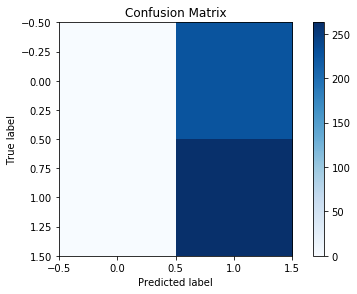

In [111]:
# create a confusion matrix
y_true = cleaned_data['party']
y_pred = cleaned_data['dummy_predict']

conf = confusion_matrix(y_true, y_pred)
print ("Baseline Accuracy:      %0.2f"% (conf[0, 0] + conf[1, 1] / (conf[0, 0] + conf[0, 1] + conf[1, 0] + conf[1, 1])))

print ('\n')
print(conf)

print ('\n')
print ("Precision:              %0.2f" %(conf[1, 1] / (conf[0, 1] + conf[1, 1])))
print ("Recall:                 %0.2f"% (conf[1, 1] / (conf[1, 0] + conf[1, 1])))

cm = confusion_matrix(y_true, y_pred, labels=None)

# plot the confusion matrix

print ('\n')
plt.figure()
plot_confusion_matrix(cm)

In [107]:
def train_score(classifier, x, y):
    
    # split data into to training and test sets
    xtrain, xtest, ytrain, ytest = cross_validation.train_test_split(x, y, test_size=0.2, random_state=1234)
    ytrain = np.ravel(ytrain)
    
    # fit a model
    clf = classifier.fit(xtrain, ytrain)
    
    # score the model (accuracy)
    train_acc = clf.score(xtrain, ytrain)
    test_acc = clf.score(xtest, ytest)
    print("Training Data Accuracy: %0.2f" %(train_acc))
    print("Test Data Accuracy:     %0.2f" %(test_acc))
  

    # create a confusion matrix
    y_true = ytest
    y_pred = clf.predict(xtest)
    
    conf = confusion_matrix(y_true, y_pred)
    print ('\n')
    print(conf)

    print ('\n')
    print ("Precision:              %0.2f" %(conf[1, 1] / (conf[0, 1] + conf[1, 1])))
    print ("Recall:                 %0.2f"% (conf[1, 1] / (conf[1, 0] + conf[1, 1])))

    cm = confusion_matrix(y_true, y_pred, labels=None)

    # plot the confusion matrix

    print ('\n')
    plt.figure()
    plot_confusion_matrix(cm)

In [108]:
x = cleaned_data['tweet_count'].reshape(-1,1)

xtrain, xtest, ytrain, ytest = train_test_split(x, cleaned_data['party'], 
                                                test_size=0.2, random_state=42)

/Users/tmoeller/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """Entry point for launching an IPython kernel.


In [109]:
np.any(np.isnan(xtrain))

False

Training Data Accuracy: 0.64
Test Data Accuracy:     0.62


[[17 25]
 [ 5 32]]


Precision:              0.56
Recall:                 0.86




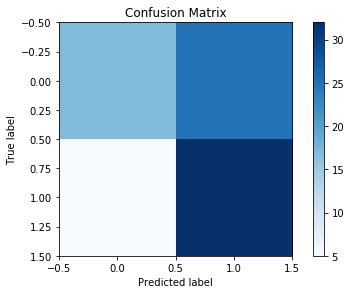

In [110]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
train_score(log_reg, xtrain, ytrain)